
Running experiments for simple function...


Testing simple function: 100%|██████████| 5/5 [02:37<00:00, 31.44s/it]


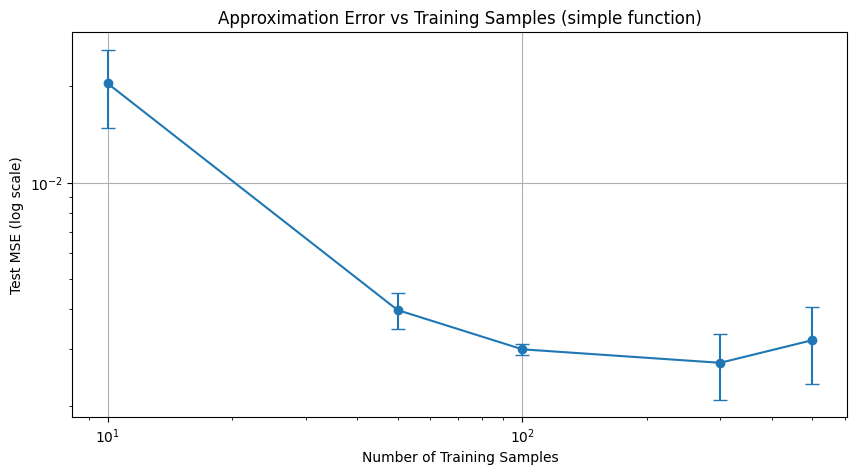

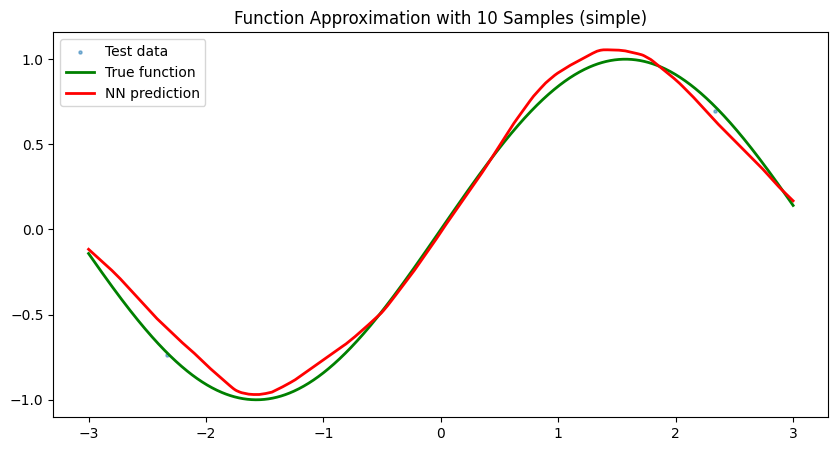

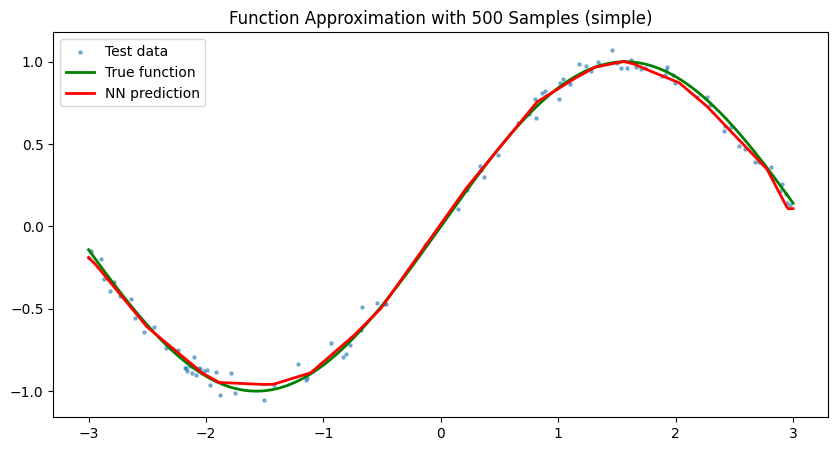


Running experiments for medium function...


Testing medium function: 100%|██████████| 5/5 [02:30<00:00, 30.05s/it]


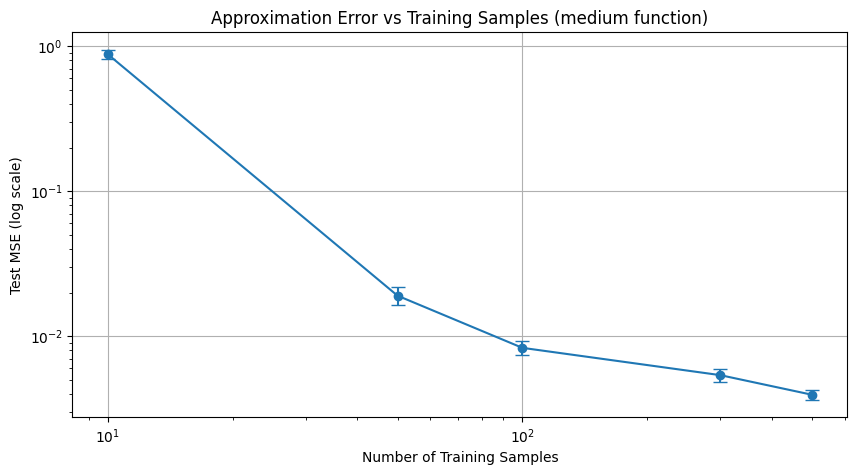

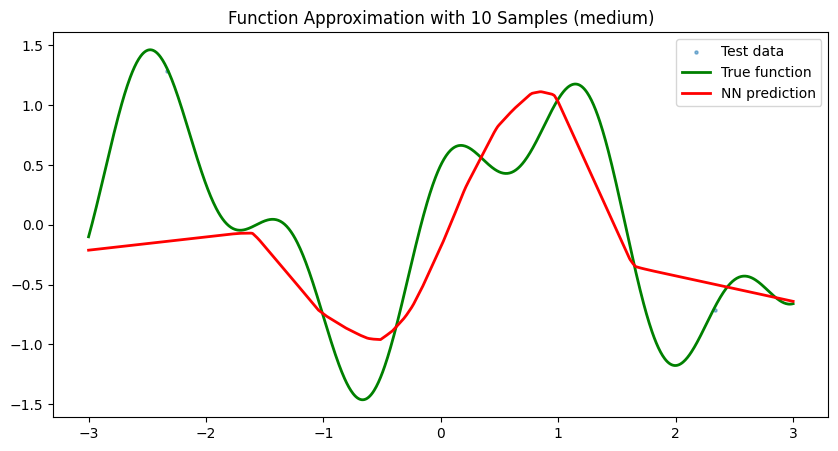

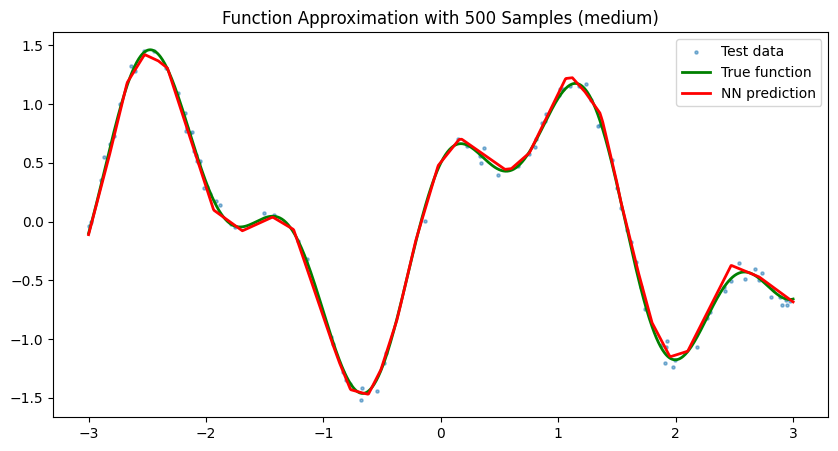


Running experiments for complex function...


Testing complex function: 100%|██████████| 5/5 [02:34<00:00, 30.95s/it]


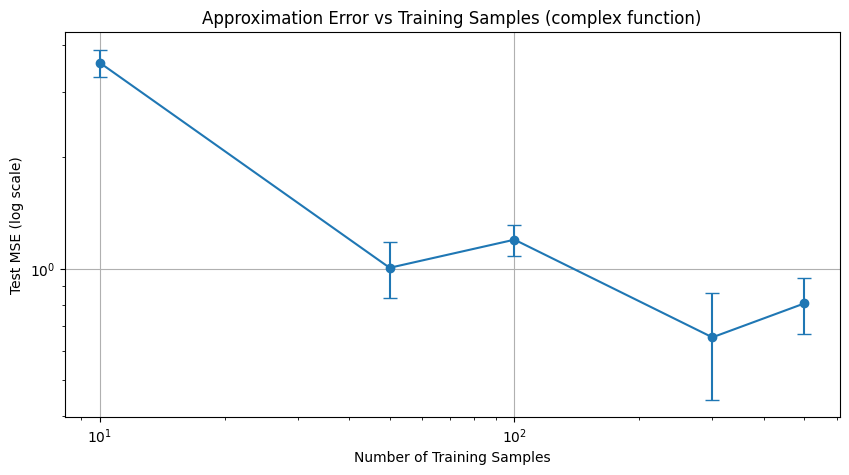

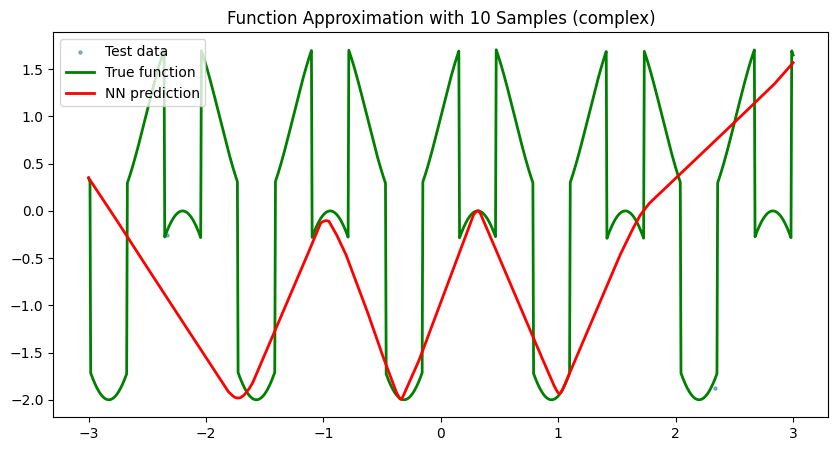

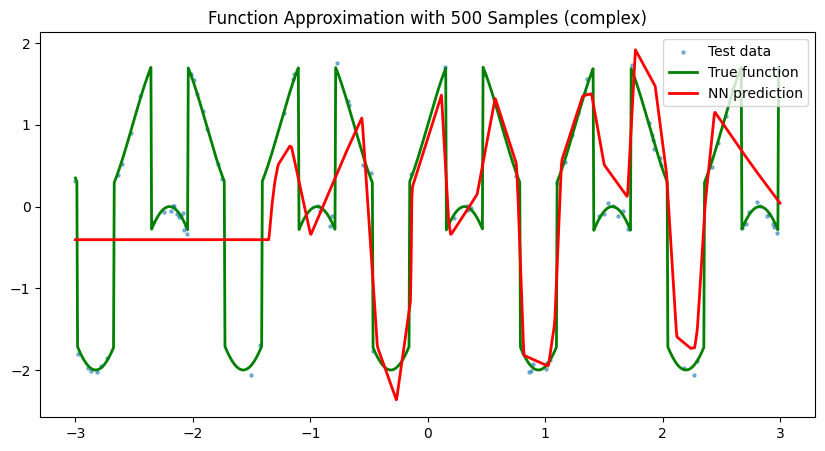

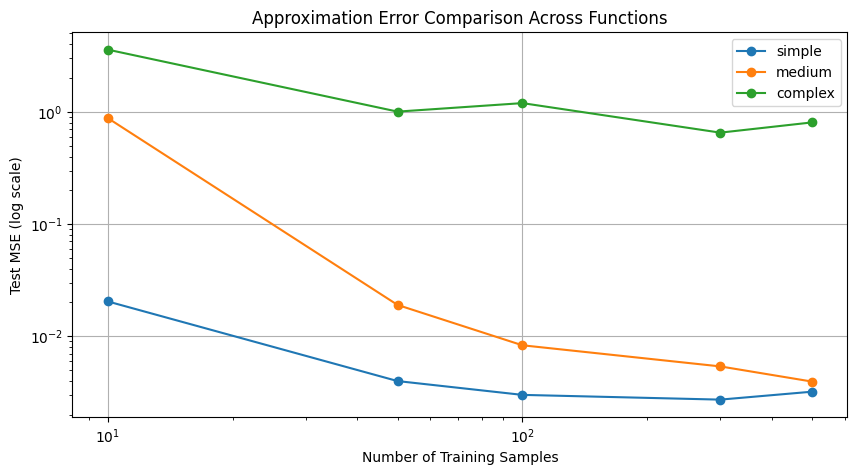

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 设备配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. 定义目标函数
def target_function(x, func_type='simple'):
    if func_type == 'simple':
        return np.sin(x)
    elif func_type == 'medium':
        return np.sin(2*x) + 0.5*np.cos(5*x)
    elif func_type == 'complex':
        return np.sin(5*x) + np.sign(np.cos(10*x))
    else:
        raise ValueError("Unknown function type")

# 2. 数据生成函数
def generate_data(func_type, n_samples, noise_level=0.05):
    x = np.linspace(-3, 3, n_samples)
    y = target_function(x, func_type)
    y += noise_level * np.random.randn(n_samples)
    return x, y

# 3. 神经网络模型
class FunctionApproximator(nn.Module):
    def __init__(self, hidden_size=64):
        super(FunctionApproximator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        return self.net(x)

# 4. 训练函数
def train_model(x_train, y_train, x_test, y_test, hidden_size=64, epochs=1000, lr=0.01, batch_size=32):
    # 转换为tensor
    x_train_t = torch.FloatTensor(x_train).unsqueeze(1).to(device)
    y_train_t = torch.FloatTensor(y_train).unsqueeze(1).to(device)
    x_test_t = torch.FloatTensor(x_test).unsqueeze(1).to(device)
    y_test_t = torch.FloatTensor(y_test).unsqueeze(1).to(device)

    # 创建数据集和数据加载器
    train_dataset = TensorDataset(x_train_t, y_train_t)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # 初始化模型
    model = FunctionApproximator(hidden_size).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # 训练
    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        model.train()
        batch_losses = []
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        train_losses.append(np.mean(batch_losses))

        # 评估
        model.eval()
        with torch.no_grad():
            test_outputs = model(x_test_t)
            test_loss = criterion(test_outputs, y_test_t)
            test_losses.append(test_loss.item())

    return model, train_losses, test_losses

# 5. 实验运行函数
def run_experiment(func_type, sample_sizes, n_repeats=3):
    results = {}

    for n_samples in tqdm(sample_sizes, desc=f"Testing {func_type} function"):
        test_mses = []
        models = []

        for _ in range(n_repeats):
            # 生成数据
            x, y = generate_data(func_type, n_samples)

            # 划分训练测试集 (80-20)
            x_train, x_test, y_train, y_test = train_test_split(
                x, y, test_size=0.2, random_state=42)

            # 训练模型
            model, train_losses, test_losses = train_model(
                x_train, y_train, x_test, y_test, epochs=1000)

            test_mses.append(test_losses[-1])  # 最终测试MSE
            models.append(model)

        # 保存结果
        results[n_samples] = {
            'mean_test_mse': np.mean(test_mses),
            'std_test_mse': np.std(test_mses),
            'models': models,
            'x_test': x_test,
            'y_test': y_test
        }

    return results

# 6. 可视化函数
def plot_results(results, func_type):
    # 绘制MSE随样本数量的变化
    sample_sizes = sorted(results.keys())
    mean_mses = [results[n]['mean_test_mse'] for n in sample_sizes]
    std_mses = [results[n]['std_test_mse'] for n in sample_sizes]

    plt.figure(figsize=(10, 5))
    plt.errorbar(sample_sizes, mean_mses, yerr=std_mses, fmt='-o', capsize=5)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of Training Samples')
    plt.ylabel('Test MSE (log scale)')
    plt.title(f'Approximation Error vs Training Samples ({func_type} function)')
    plt.grid(True)
    plt.show()

    # 绘制拟合效果示例
    for n_samples in [min(sample_sizes), max(sample_sizes)]:
        model = results[n_samples]['models'][0]  # 取第一个重复实验的模型
        x_test = results[n_samples]['x_test']
        y_test = results[n_samples]['y_test']

        # 预测
        with torch.no_grad():
            x_plot = np.linspace(-3, 3, 1000)
            y_true = target_function(x_plot, func_type)
            y_pred = model(torch.FloatTensor(x_plot).unsqueeze(1).to(device)).cpu().numpy()

        # 绘制
        plt.figure(figsize=(10, 5))
        plt.scatter(x_test, y_test, s=5, alpha=0.5, label='Test data')
        plt.plot(x_plot, y_true, 'g-', linewidth=2, label='True function')
        plt.plot(x_plot, y_pred, 'r-', linewidth=2, label='NN prediction')
        plt.title(f'Function Approximation with {n_samples} Samples ({func_type})')
        plt.legend()
        plt.show()

# 7. 主函数
def main():
    # 实验参数
    sample_sizes = [10, 50, 100, 300, 500]
    func_types = ['simple', 'medium', 'complex']

    # 运行实验
    all_results = {}
    for func_type in func_types:
        print(f"\nRunning experiments for {func_type} function...")
        results = run_experiment(func_type, sample_sizes)
        all_results[func_type] = results
        plot_results(results, func_type)

    # 综合比较不同函数的逼近难度
    plt.figure(figsize=(10, 5))
    for func_type in func_types:
        sample_sizes = sorted(all_results[func_type].keys())
        mean_mses = [all_results[func_type][n]['mean_test_mse'] for n in sample_sizes]
        plt.plot(sample_sizes, mean_mses, '-o', label=func_type)

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of Training Samples')
    plt.ylabel('Test MSE (log scale)')
    plt.title('Approximation Error Comparison Across Functions')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == '__main__':
    main()